### Importing required libraries

In [10]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow import keras
### Use GPU if available
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Reading JSON data

In [4]:
with open("MFCC.json", 'r') as fp:
    mfcc = json.load(fp)

### Preparing data for DL

In [5]:
X = np.array(mfcc['mfcc'])
target = np.array(mfcc['type'])

In [6]:
normal = []
y = []

mapping = {
    'normal' : 0,
    'murmur' : 1,
    'artifact' : 2,
    'extrastole' : 3,
    'extrahls' : 4
}

for i in range(len(target)):
    y.append(mapping[target[i]])
    if target[i] == 'normal':
        normal.append(0)
    else:
        normal.append(1)

y = np.array(y)
normal = np.array(normal)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, normal, test_size= 0.2, stratify= normal)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size= 0.2, stratify= y_train)

In [8]:
X_train_cnn = X_train[..., np.newaxis]
X_validate_cnn = X_validate[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

In [22]:
obs = list(pd.DataFrame(y_train).value_counts().sort_index())
lent = len(obs)
weights = []
for i in range(0, lent):
    weights.append(sum(obs)/obs[i])
    
#sum_weights = sum(weights)
#for i in range(5):
#    weights[i] = weights[i]/sum_weights

class_weight = {}
for i in range(lent):
    class_weight[i] = weights[i]
class_weight

{0: 1.863888888888889, 1: 2.157556270096463}

### Building the model for binary classification

In [42]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(16, (3,1), activation='relu', padding='same', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], X_train_cnn.shape[3])))
model.add(keras.layers.MaxPool2D((2,1), strides=(2, 1), padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(1, activation='sigmoid'))

In [43]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 130, 30, 16)       64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 65, 30, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 65, 30, 16)        64        
_________________________________________________________________
flatten_3 (Flatten)          (None, 31200)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                499216    
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [44]:
history = model.fit(X_train_cnn, y_train, validation_data=(X_validate_cnn, y_validate), batch_size=32, epochs=30, class_weight=class_weight)

Epoch 1/30
21/21 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.5261 - val_loss: nan - val_accuracy: 0.5357
Epoch 2/30
21/21 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5365 - val_loss: nan - val_accuracy: 0.5357
Epoch 3/30
21/21 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5365 - val_loss: nan - val_accuracy: 0.5357
Epoch 4/30
21/21 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5365 - val_loss: nan - val_accuracy: 0.5357
Epoch 5/30
21/21 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.5365 - val_loss: nan - val_accuracy: 0.5357
Epoch 6/30
21/21 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.5365 - val_loss: nan - val_accuracy: 0.5357
Epoch 7/30
21/21 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.5365 - val_loss: nan - val_accuracy: 0.5357
Epoch 8/30
21/21 [==============================] - 0s 5ms/ste

In [45]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label='train accuracy')
    axs[0].plot(history.history['val_accuracy'], label='test accuracy')
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # create error subplot
    axs[1].plot(history.history['loss'], label='train error')
    axs[1].plot(history.history['val_loss'], label='test error')
    axs[1].set_ylabel("Error")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.show()

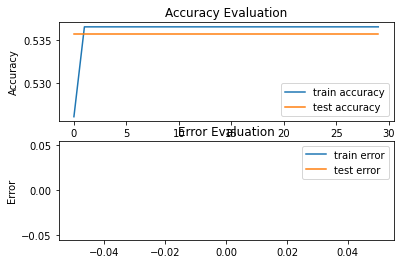

In [46]:
plot_history(history)

In [47]:
# evaluate the CNN on the test set
test_error, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=2)
print("Accuracy on test set is: {}".format(test_accuracy))
print("Error on test set is: {}".format(test_error))
print("\n\n")

# evaluate the CNN on the train set
test_error, test_accuracy = model.evaluate(X_train_cnn, y_train, verbose=2)
print("Accuracy on train set is: {}".format(test_accuracy))
print("Error on train set is: {}".format(test_error))
print("\n\n")

# evaluate the CNN on the validation set
test_error, test_accuracy = model.evaluate(X_validate_cnn, y_validate, verbose=2)
print("Accuracy on validation set is: {}".format(test_accuracy))
print("Error on validation set is: {}".format(test_error))

7/7 - 0s - loss: nan - accuracy: 0.5381
Accuracy on test set is: 0.538095235824585
Error on test set is: nan



21/21 - 0s - loss: nan - accuracy: 0.5365
Accuracy on train set is: 0.5365126729011536
Error on train set is: nan



6/6 - 0s - loss: nan - accuracy: 0.5357
Accuracy on validation set is: 0.5357142686843872
Error on validation set is: nan


<AxesSubplot:>

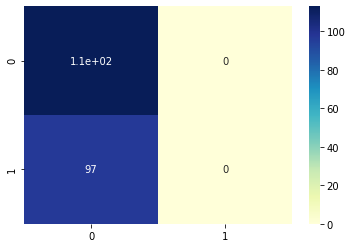

In [48]:
y_pred = np.argmax(model.predict(X_test_cnn),axis=1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGnBu")

## Building the model for Multi class classification

In [49]:
X = np.array(mfcc['mfcc'])
y = np.array(mfcc['type'])

y = []

mapping = {
    'normal' : 0,
    'murmur' : 1,
    'artifact' : 2,
    'extrastole' : 3,
    'extrahls' : 4
}

for i in range(len(target)):
    y.append(mapping[target[i]])

y = np.array(y)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= y)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size= 0.2, stratify= y_train)

In [51]:
obs = list(pd.DataFrame(y_train).value_counts().sort_index())
obs

[360, 169, 77, 41, 24]

In [52]:
weights = []
for i in range(0, 5):
    weights.append(sum(obs)/obs[i])
    
#sum_weights = sum(weights)
#for i in range(5):
#    weights[i] = weights[i]/sum_weights

class_weight = {
    0 : weights[0],
    1 : weights[1],
    2 : weights[2],
    3 : weights[3],
    4 : weights[4]
}

In [53]:
class_weight

{0: 1.863888888888889,
 1: 3.970414201183432,
 2: 8.714285714285714,
 3: 16.365853658536587,
 4: 27.958333333333332}

In [54]:
X_train_cnn = X_train[..., np.newaxis]
X_validate_cnn = X_validate[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

In [55]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, (3,1), activation='relu', padding='same', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], X_train_cnn.shape[3])))
model.add(keras.layers.MaxPool2D((2,1), strides=(2, 1), padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 1), activation='relu'))
model.add(keras.layers.MaxPool2D((2,1), strides=(2, 1), padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(5, activation='softmax'))

In [56]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer= optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 130, 30, 32)       128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 65, 30, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 65, 30, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 63, 30, 64)        6208      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 30, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 30, 64)        256       
_________________________________________________________________
flatten_4 (Flatten)          (None, 61440)            

In [57]:
history = model.fit(X_train_cnn, y_train, validation_data=(X_validate_cnn, y_validate), batch_size=64, epochs=60, class_weight=class_weight)

Epoch 1/60
11/11 [==============================] - 0s 37ms/step - loss: 9.1577 - accuracy: 0.2981 - val_loss: 3.0684 - val_accuracy: 0.1131
Epoch 2/60
11/11 [==============================] - 0s 16ms/step - loss: 5.9710 - accuracy: 0.4396 - val_loss: 1.9640 - val_accuracy: 0.1310
Epoch 3/60
11/11 [==============================] - 0s 16ms/step - loss: 5.7334 - accuracy: 0.2578 - val_loss: 1.6430 - val_accuracy: 0.1548
Epoch 4/60
11/11 [==============================] - 0s 16ms/step - loss: 5.4607 - accuracy: 0.3875 - val_loss: 1.5726 - val_accuracy: 0.2619
Epoch 5/60
11/11 [==============================] - 0s 16ms/step - loss: 5.4580 - accuracy: 0.3770 - val_loss: 1.4778 - val_accuracy: 0.1548
Epoch 6/60
11/11 [==============================] - 0s 16ms/step - loss: 5.3939 - accuracy: 0.3219 - val_loss: 1.3309 - val_accuracy: 0.3274
Epoch 7/60
11/11 [==============================] - 0s 16ms/step - loss: 4.7218 - accuracy: 0.3756 - val_loss: 1.3520 - val_accuracy: 0.3690
Epoch 8/60
11

Epoch 59/60
11/11 [==============================] - 0s 15ms/step - loss: 2.6343 - accuracy: 0.6259 - val_loss: 0.7657 - val_accuracy: 0.6964
Epoch 60/60
11/11 [==============================] - 0s 15ms/step - loss: 2.7747 - accuracy: 0.6349 - val_loss: 0.8049 - val_accuracy: 0.6905


In [58]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label='train accuracy')
    axs[0].plot(history.history['val_accuracy'], label='test accuracy')
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # create error subplot
    axs[1].plot(history.history['loss'], label='train error')
    axs[1].plot(history.history['val_loss'], label='test error')
    axs[1].set_ylabel("Error")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.show()

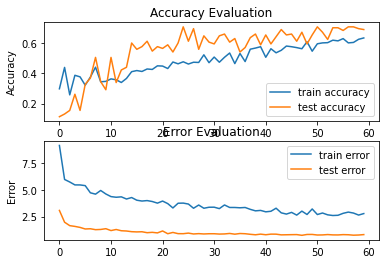

In [59]:
plot_history(history)

In [60]:
# evaluate the CNN on the test set
test_error, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=2)
print("Accuracy on test set is: {}".format(test_accuracy))
print("Error on test set is: {}".format(test_error))
print("\n\n")

# evaluate the CNN on the train set
test_error, test_accuracy = model.evaluate(X_train_cnn, y_train, verbose=2)
print("Accuracy on train set is: {}".format(test_accuracy))
print("Error on train set is: {}".format(test_error))
print("\n\n")

# evaluate the CNN on the validation set
test_error, test_accuracy = model.evaluate(X_validate_cnn, y_validate, verbose=2)
print("Accuracy on validation set is: {}".format(test_accuracy))
print("Error on validation set is: {}".format(test_error))

7/7 - 0s - loss: 0.7865 - accuracy: 0.7286
Accuracy on test set is: 0.7285714149475098
Error on test set is: 0.7864954471588135



21/21 - 0s - loss: 0.2104 - accuracy: 0.9687
Accuracy on train set is: 0.9687034487724304
Error on train set is: 0.21036532521247864



6/6 - 0s - loss: 0.8049 - accuracy: 0.6905
Accuracy on validation set is: 0.6904761791229248
Error on validation set is: 0.8048645257949829


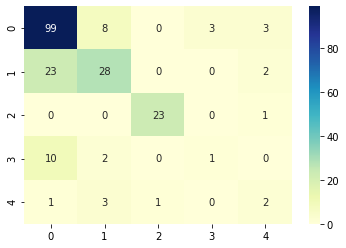

In [61]:
y_pred = np.argmax(model.predict(X_test_cnn),axis=1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGnBu")